## Demonstration of SHyFT API implementation of Kalman Filtering on time series


### This notebook gives an example of Met.no data post-processing to correct temperature forecasts based on comparison to observations. The following steps are described:
1. **Loading required python modules and setting path to SHyFT installation**
2. **Generate synthetic data for temperature observations and forecasts time-series**
3. **Calculate the bias time-series using Kalman filter**
4. **Apply bias to forecasts**
5. **Plot the results**

### 1. Loading required python modules and setting path to SHyFT installation

In [1]:
# first you should import the third-party python modules which you'll use later on
# the first line enables that figures are shown inline, directly in the notebook
%pylab inline
import os
from os import path
import sys
from matplotlib import pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [7]:
# once the shyft_path is set correctly, you should be able to import shyft modules

from shyft.hydrology import shyftdata_dir

# if you have problems here, it may be related to having your LD_LIBRARY_PATH
# pointing to the appropriate libboost_python libraries (.so files)
from shyft.hydrology.repository.default_state_repository import DefaultStateRepository
from shyft.hydrology.orchestration.configuration import yaml_configs
from shyft.hydrology.orchestration.simulators.config_simulator import ConfigSimulator
import shyft.hydrology as api
import shyft.time_series as sts

In [5]:
# now you can access the api of shyft with tab completion and help, try this:

#help(api.GeoPoint) # remove the hashtag and run the cell to print the documentation of the api.GeoPoint class
#api. # remove the hashtag, set the pointer behind the dot and use 
      # tab completion to see the available attributes of the shyft api

### 2. Generate synthetic data for temperature observations and forecasts time-series

In [8]:
# Create a time-axis
t0 = sts.Calendar().time(2016, 1, 1)
ta = sts.TimeAxis(t0, sts.deltahours(1), 240)

# Create a TemperatureSourceVector to hold the set of observation time-series
obs_set = api.TemperatureSourceVector()

# Create a time-series having a constant temperature of 15 at a GeoPoint(100, 100, 100)
ts = sts.TimeSeries(ta, fill_value=15.0,point_fx=sts.POINT_AVERAGE_VALUE)
geo_ts = api.TemperatureSource(api.GeoPoint(100, 100, 100), ts)
obs_set.append(geo_ts)

In [9]:
# Create a TemperatureSourceVector to hold the set of forecast time-series
fc_set = api.TemperatureSourceVector()

# Create a time-series having constant offset of 2 and add it to the set of observation time-series
off_ts = sts.TimeSeries(ta, fill_value=2.0,point_fx=sts.POINT_AVERAGE_VALUE)
for obs in obs_set:
    fc_ts = api.TemperatureSource(obs.mid_point(), obs.ts + off_ts)
    fc_set.append(fc_ts)

### 3. Calculate the bias time-series using Kalman filter

In [12]:
# Create a TemperatureSourceVector to hold the set of bias time-series
bias_set = api.TemperatureSourceVector()

# Create the Kalman filter having 8 samples spaced every 3 hours to represent a daily periodic pattern
kf = api.KalmanFilter()
kbp = api.KalmanBiasPredictor(kf)
kta = sts.TimeAxis(t0, sts.deltahours(3), 8)

# Calculate the coefficients of Kalman filter and 
# Create bias time-series based on the daily periodic pattern
for obs in obs_set:
    kbp.update_with_forecast(fc_set, obs.ts, kta)
    pattern = api.KalmanState.get_x(kbp.state) * np.array(-1.0) # By convention, inverse sign of pattern values
    bias_ts = sts.create_periodic_pattern_ts(pattern, sts.deltahours(3), ta.time(0), ta)
    bias_set.append(api.TemperatureSource(obs.mid_point(), bias_ts))

### 4. Apply bias to forecasts

In [13]:
# Correct the set of forecasts by applying the set of bias time-series
for i in range(len(fc_set)):
    fc_set[i].ts += bias_set[i].ts # By convention, add bias time-series

In [14]:
# Check the last value of the time-series. It should be around 15
print(fc_set[0].ts.value(239))

15.836980529266755


### 5. Plot the results

Text(0, 0.5, 'Temp ($^\\circ$C)')

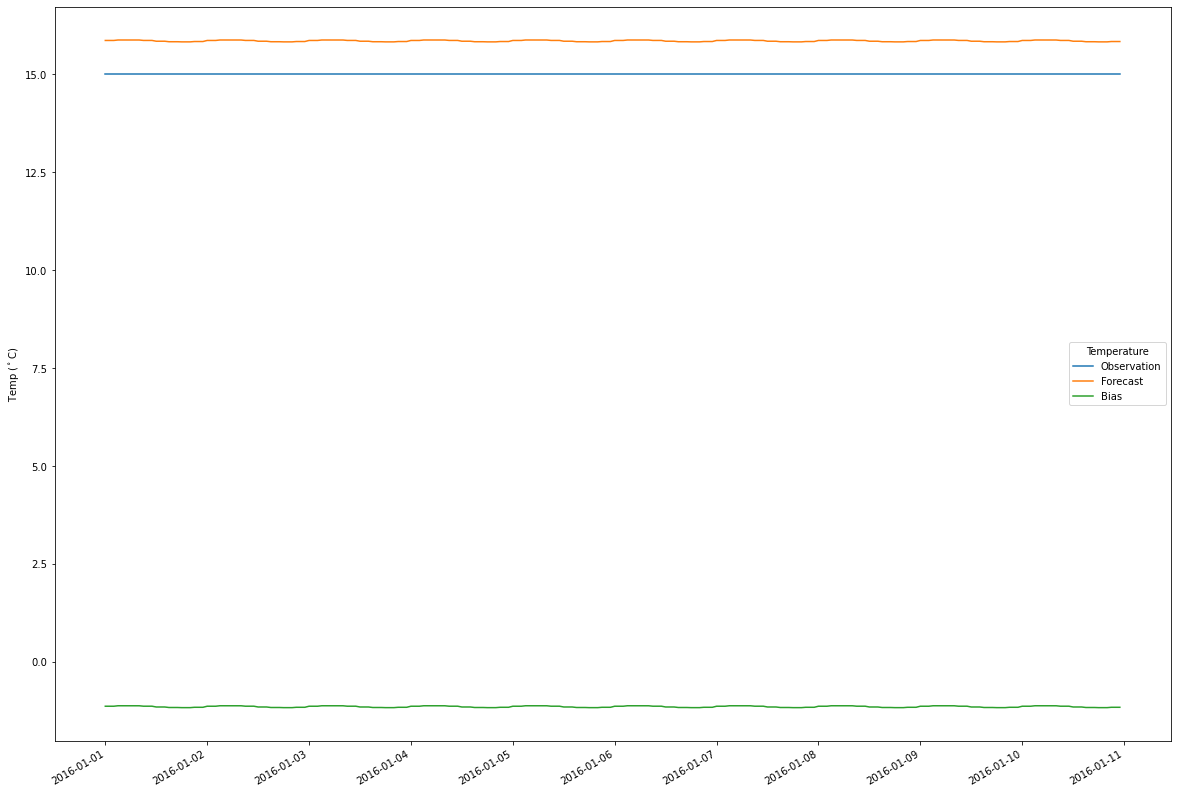

In [15]:
fig, ax = plt.subplots(figsize=(20,15))
for i in range(len(bias_set)):
    obs = obs_set[i]
    fc = fc_set[i]
    bias = bias_set[i]
    timestamps = [datetime.datetime.utcfromtimestamp(p) for p in obs.ts.time_axis.time_points]
    ax.plot(timestamps[:-1], obs.ts.values, label = 'Observation')
    ax.plot(timestamps[:-1], fc.ts.values, label = 'Forecast')
    ax.plot(timestamps[:-1], bias.ts.values, label = 'Bias')
fig.autofmt_xdate()
ax.legend(title='Temperature')
ax.set_ylabel('Temp ($^\circ$C)')